In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# %matplotlib ipympl

Define the parameters and geometry for the simulation.

In [2]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [2, 3, 2]

reverberation distance is 0.5426201661567753m
reverberation time is 1.228475783983933s


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_48912/841666457.py:36: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi_new.set_wall_scattering(


Calculate old slow approach for comparison.

In [ ]:
start = datetime.now()
# init object
radi = sp.radiosity.Radiosity(
    walls, patch_size, max_order_k, ir_length_s,
    speed_of_sound=speed_of_sound, sampling_rate=sampling_rate)

# run simulation
radi.run(source)

# gather energy at receiver
receiver = sp.geometry.Receiver(receiver_pos, [0, 1, 0], [0, 0, 1])
ir_slow = radi.energy_at_receiver(receiver, ignore_direct=True)
reverberation_slow = pf.Signal(ir_slow, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Calculate new fast approach

In [4]:
start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))

# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(algorithm='order')

# initialize source energy at each patch
radiosity_fast.init_source_energy(source_pos, algorithm='order')

# gather energy at receiver
ir_fast = radiosity_fast.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)
reverberation_fast = pf.Signal(ir_fast, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Calculate the analytical reference after Kuttruff.

In [9]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
E_reverb_analytical = 4/A
t = reverberation_fast.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.Signal(
    reverberation_analytic, sampling_rate=sampling_rate)

Plot comparison

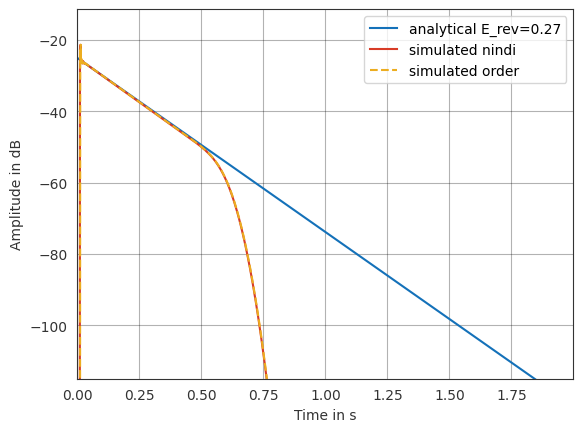

In [10]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')
pf.plot.time(
    reverberation_slow, dB=True, log_prefix=10,
    label=f'simulated slow ({slow_time_s:0.2f}s)',
    linestyle='-')
pf.plot.time(
    reverberation_fast, dB=True, log_prefix=10,
    label=f'simulated fast ({fast_time_s:0.2f}s)',
    linestyle='--')

plt.legend()
plt.show()

In [ ]:
%load_ext watermark
%watermark -v -m -iv